In [22]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob

from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from time import time
from scipy.ndimage.measurements import label
from mpl_toolkits.mplot3d import Axes3D
from moviepy.editor import VideoFileClip

In [23]:
# Get images of cars and non-cars to train the classifier
cars = list(glob.iglob('./data/vehicles/**/*.png', recursive=True))
notcars = list(glob.iglob('./data/non-vehicles/**/*.png', recursive=True))

In [24]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [25]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [26]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [27]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [28]:
# Let's extract the features now to train the classifier.
# The following settings worked well.

color_space = 'YCrCb' 
spatial_size = (16, 16)
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' 
hist_bins = 64
spatial_feat=True
hist_feat=True
hog_feat=True

t = time()

# Get car and non-car features and corresponding classes

car_features = extract_features(imgs=cars, 
                                color_space=color_space, 
                                spatial_size=spatial_size,
                                hist_bins=hist_bins,
                                orient=orient,
                                pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel,
                                spatial_feat=spatial_feat,
                                hist_feat=hist_feat,
                                hog_feat=hog_feat)
  
notcar_features = extract_features(imgs=notcars, 
                                color_space=color_space, 
                                spatial_size=spatial_size,
                                hist_bins=hist_bins,
                                orient=orient,
                                pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel,
                                spatial_feat=spatial_feat,
                                hist_feat=hist_feat,
                                hog_feat=hog_feat)    

t2 = time()
print(round(t2-t, 2), 'Seconds to extract features...')

50.95 Seconds to extract features...


In [29]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = 42
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

In [30]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Let's train a linear SVM
svc = LinearSVC(random_state=42, penalty='l2', C=0.001, loss='squared_hinge', dual=True)

# Fit the model
t = time()
svc.fit(X_train, y_train)
t2 = time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t = time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 2148
1.28 Seconds to train SVC...
Test Accuracy of SVC =  0.989
My SVC predicts:  [ 0.  0.  0.  1.  1.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  0.  0.  1.  1.  1.  1.  0.  0.  0.]
0.00243 Seconds to predict 10 labels with SVC


In [31]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [32]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [33]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [34]:
# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32, 32), hist_bins=32,
                   hist_range=(0, 256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):
    # 1) Create an empty list to receive positive detection windows
    on_windows = []
    # 2) Iterate over all windows in the list
    for window in windows:
        # 3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # 4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)
        # 5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # 6) Predict using your classifier
        # print test_features
        prediction = clf.predict(test_features)
        # print prediction
        # 7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # 8) Return windows for positive detections
    return on_windows

In [35]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap

In [36]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [37]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], color=(0,255,0), thickness=6)
    # Return the image
    return img

In [117]:
# Pipeline to draw bounding boxes around cars for individual images.
# It's a class with a method to do the pipeline application rather 
# than a simple function, because we need to encapsulate bounding box 
# history from the past N (e.g. 15) image frames. Otherwise, history would
# be a global variable, or a state for a coroutine, which would be less
# desirable if multiple instances of the pipeline were to be used, e.g.
# for testing. The reason for the bouding box history from multiple frames
# is that spurious detections are likely to be transient (if our classifier
# is trained correctly), while correct detections will span multiple frames
# as the detected car moves slowly around the image frame. So, with multiple
# frames, we can detect boxes at multiple frames, merge them if they are close
# to each other, and raise the detection threshold. This will keep the
# consistent detections and eliminate the false positives.
class Pipeline:
    
    # The constructor takes a list of window functions (that take an image and
    # apply sliding windows with different start-stop (x, y) ranges in the image,
    # different window overlaps, etc., as well as a time window (for how many
    # consecutive images to count the bounding boxes to be thresholded and merged),
    # the threshold to be applied, and the heat minimum and maximum clipping.
    def __init__(
        self,
        window_funs,
        time_window = 15,
        app_threshold = 9,
        heat_clip_min = 0,
        heat_clip_max = 255,
        trigger = 10
    ):
        self.time_window = time_window
        self.app_threshold = app_threshold
        self.heat_clip_min = heat_clip_min
        self.heat_clip_max = heat_clip_max
        self.window_funs = window_funs
        self.box_history = []
        self.counter = 0
        self.trigger = trigger
        
    # Pipeline application - makes the object callable, i.e.
    # we can pass my_object that's as a lambda rather than passing
    # my_object.apply_pipeline as a lambda to the video function.
    def __call__(self, image):
        
        self.counter += 1
        
        # Make a copy, don't mutate the orginal image. We'll need
        # this image later to draw boxes on it. The copy we make below
        # of the scaled image is to calculate the boxes, but we'll need
        # this original to draw the boxes on later.
        orig_img = np.copy(image)
        # SVM training and the original pipeline was done based on
        # PNGs, which are provided by Matplotlib image library in
        # the range [0, 1] as floats, but the video library provides
        # JPEGs and reads them as uint8 with a range [0, 255], so 
        # we need this conversion here.
        image = image.astype(np.float32) / 255
        # Again, we don't want to mutate the underlying image.
        draw_image = np.copy(image)
        # Pre-allocate memory for the heat map.
        heat = np.zeros_like(draw_image[:, :, 0]).astype(np.float)
        # Create the first list of sliding windows. The list
        # of lambdas to apply may be longer than one item, 
        # but we need to initialize with the first list produced
        # by the first lambda to concatenate the window list later.
        windows = self.window_funs[0](image)
        # If there are more lambdas for the sliding windows to apply,
        # loop over them and then concatenate the window list.
        for win in range(1, len(self.window_funs)):
            windows = windows + self.window_funs[win](image)         
        
        # Once we have the window boundaries, let's get the features
        # for these windows and apply the classifier.
        hot_windows = search_windows(draw_image, windows, svc,
                                     X_scaler, color_space=color_space,
                                     spatial_size=spatial_size,
                                     hist_bins=hist_bins,
                                     orient=orient, 
                                     pix_per_cell=pix_per_cell,
                                     cell_per_block=cell_per_block,
                                     hog_channel=hog_channel,
                                     spatial_feat=spatial_feat,
                                     hist_feat=hist_feat,
                                     hog_feat=hog_feat)
        
        # Let's skip the first 30 frames. Technically we can
        # just skip the first N frames, where N is the time_window
        # value (15 for the successful experiment), but here I skip
        # 30 because there are some artifacts in the first second of
        # the video when there are no cars present.
        if len(self.box_history) < 15:
            self.box_history.append(hot_windows)
            return draw_image
        # One the image history has been initialized,
        # start drawing boxes.
        else:
            
            fig0 = plt.figure()
            image2 = np.copy(image)
            image2 *= 255
            image2 = image2.astype(np.uint8)
            image2 = draw_boxes(image2, windows, color=(0, 255, 0), thick=6)
            plt.imshow(image2)
            plt.show()
            
            # Since we have the history of boxes that's full now,
            # we need to drop the oldest frame, add the latest frame
            # and predict over the moving time window.
            self.box_history = self.box_history[1:]
            self.box_history.append(hot_windows)
            # Accumulate list of boxes of the the time_window
            # number of video frames. Not doing this on just
            # one frame allows us to raise the detection threshold
            # since with a well-trained classifier, false positives
            # are likely to be transient, while true positives are
            # likely to persist across frames, and the cars don't
            # move fast enough for the detections to be counted
            # as separate.
            previous_bboxes = []
            for bbox in self.box_history:
                previous_bboxes.extend(bbox)
                
            fig0 = plt.figure()
            image2 = np.copy(image)
            image2 *= 255
            image2 = image2.astype(np.uint8)
            image2 = draw_boxes(image2, previous_bboxes, color=(0, 255, 0), thick=6)
            plt.imshow(image2)
            plt.show()
            
            # Generate a heat map across the bounding box history.
            heat = add_heat(heat, previous_bboxes)
            # Threshold detections to remove false positives.
            heat = apply_threshold(heat, self.app_threshold)
            heatmap = np.clip(heat, self.heat_clip_min, self.heat_clip_max)
            # Create labels of overlapping bounding boxes.
            labels = label(heatmap)
            # draw bounding boxes on the original image
            labeled_image = draw_labeled_bboxes(orig_img, labels)
            
            fig = plt.figure()
            plt.subplot(121)
            plt.imshow(labeled_image)
            plt.title('Car Positions')
            plt.subplot(122)
            plt.imshow(heatmap, cmap='hot')
            plt.title('Heat Map')
            fig.tight_layout()
            plt.show()
            
            # Return annotated image
            return labeled_image

In [118]:
im = mpimg.imread(cars[0])


window_funs = [
    lambda image: slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 640],
                                xy_window= (128, 128), xy_overlap=(0.5, 0.5)),
    lambda image: slide_window(image, x_start_stop=[32, None], y_start_stop=[400, 600],
                                xy_window=(96, 96), xy_overlap=(0.5, 0.5)),
    lambda image: slide_window(image, x_start_stop=[412, 1280], y_start_stop=[390, 540],
                                xy_window=(80, 80), xy_overlap=(0.5, 0.5))
]

windows = window_funs[0](im)
for i in range(1, len(window_funs)):
    windows = windows + window_funs[i](im)

In [119]:
# Apply the image pipeline lambda to a video clip
def find_cars_in_video(input_video_path, pipeline, output_video_path):
    clip = VideoFileClip(input_video_path)
    clip_with_lines = clip.fl_image(pipeline)
    clip_with_lines.write_videofile(output_video_path, audio=False)

In [115]:
# These are the multi-region, multi-resolution sliding window
# functions to be applied to each image. The windows they
# generate will have the features extracted, the classifier will
# be applied to them, and the heat maps will be generated to 
# determine the final bounding boxes for individual cars.
window_funs = [
    lambda image: slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 640],
                                xy_window= (128, 128), xy_overlap=(0.5, 0.5)),
    lambda image: slide_window(image, x_start_stop=[32, None], y_start_stop=[400, 600],
                                xy_window=(96, 96), xy_overlap=(0.5, 0.5)),
    lambda image: slide_window(image, x_start_stop=[412, 1280], y_start_stop=[390, 540],
                                xy_window=(80, 80), xy_overlap=(0.5, 0.5))
]

# Construct the pipeline. This will contain the state of the
# history of windows from the last time_window frames, and
# other config for the pipeline lambda provided to the
# find_cars_in_video function. We could use a generator 
# instead, but that wouldn't make it easy to create several
# stateful pipelines at once.
pipeline = Pipeline(
    window_funs,
    time_window = 15,
    app_threshold = 9,
    heat_clip_min = 0,
    heat_clip_max = 255
)

[MoviePy] >>>> Building video tracking.mp4
[MoviePy] Writing video tracking.mp4









  0%|          | 0/39 [00:00<?, ?it/s]






  3%|▎         | 1/39 [00:00<00:14,  2.62it/s]






  5%|▌         | 2/39 [00:00<00:14,  2.61it/s]






  8%|▊         | 3/39 [00:01<00:14,  2.51it/s]






 10%|█         | 4/39 [00:01<00:13,  2.52it/s]






 13%|█▎        | 5/39 [00:02<00:13,  2.50it/s]






 15%|█▌        | 6/39 [00:02<00:13,  2.51it/s]






 18%|█▊        | 7/39 [00:02<00:12,  2.51it/s]






 21%|██        | 8/39 [00:03<00:12,  2.49it/s]






 23%|██▎       | 9/39 [00:03<00:12,  2.50it/s]






 26%|██▌       | 10/39 [00:04<00:12,  2.39it/s]






 28%|██▊       | 11/39 [00:04<00:11,  2.45it/s]






 31%|███       | 12/39 [00:04<00:10,  2.51it/s]






 33%|███▎      | 13/39 [00:05<00:10,  2.55it/s]






 36%|███▌      | 14/39 [00:05<00:09,  2.58it/s]

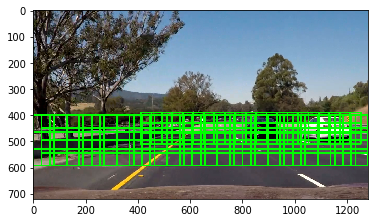

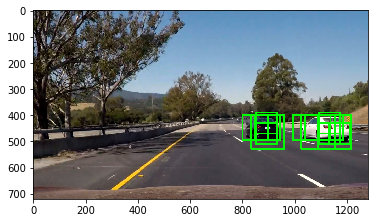

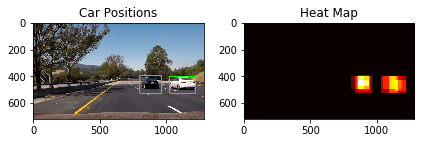








 38%|███▊      | 15/39 [00:06<00:14,  1.62it/s]

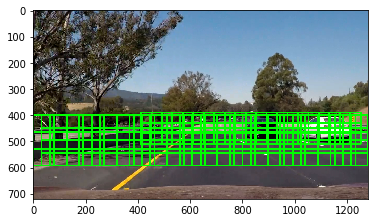

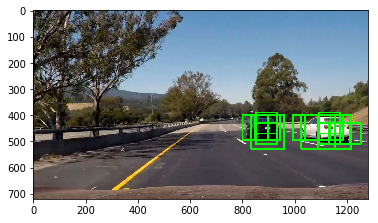

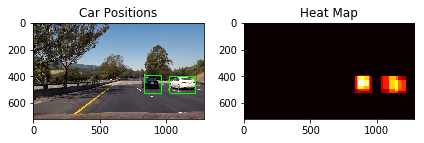








 41%|████      | 16/39 [00:07<00:17,  1.28it/s]

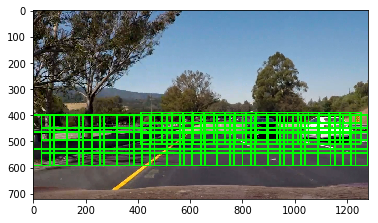

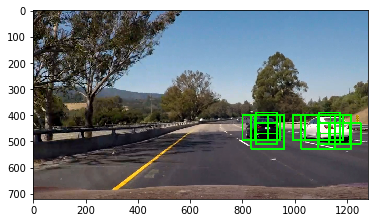

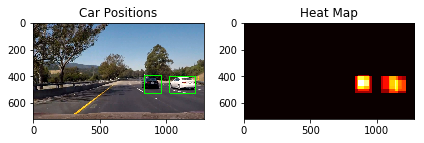








 44%|████▎     | 17/39 [00:09<00:20,  1.10it/s]

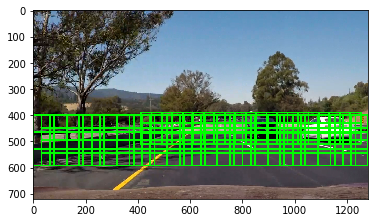

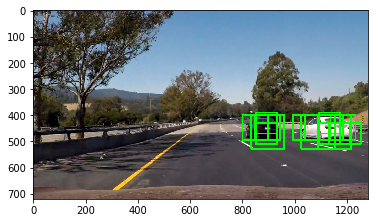

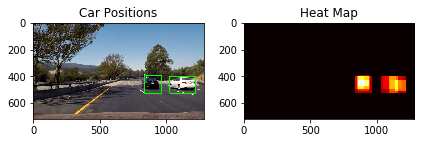








 46%|████▌     | 18/39 [00:10<00:20,  1.02it/s]

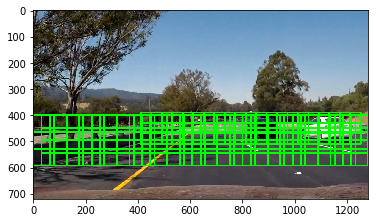

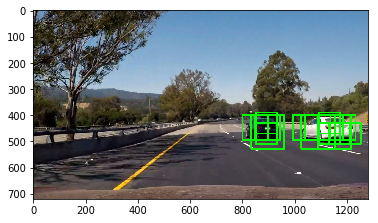

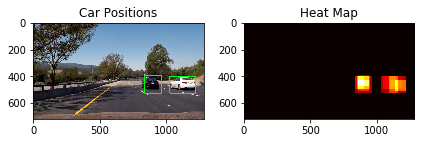








 49%|████▊     | 19/39 [00:11<00:20,  1.03s/it]

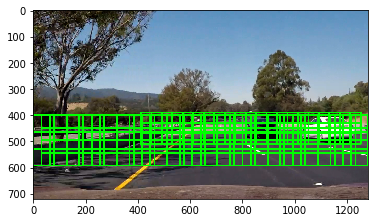

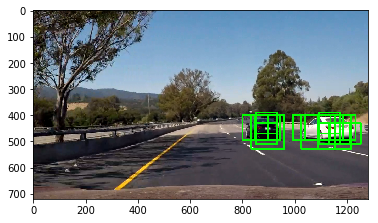

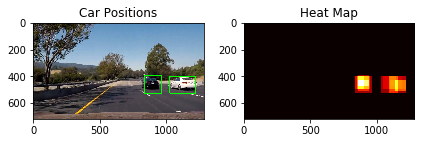








 51%|█████▏    | 20/39 [00:12<00:20,  1.08s/it]

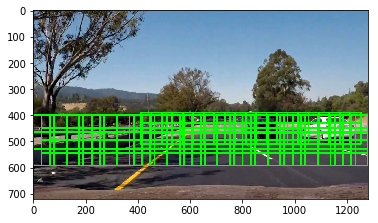

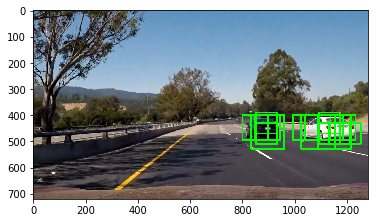

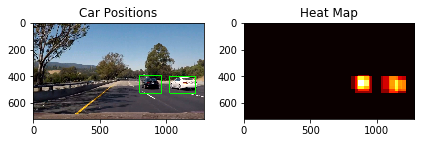








 54%|█████▍    | 21/39 [00:13<00:19,  1.10s/it]

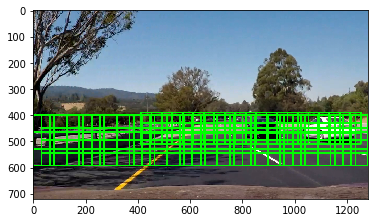

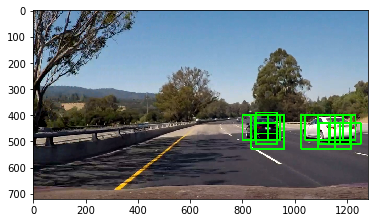

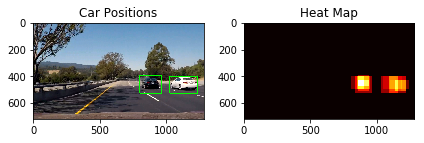








 56%|█████▋    | 22/39 [00:14<00:19,  1.12s/it]

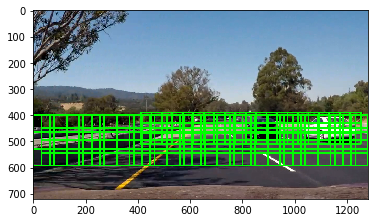

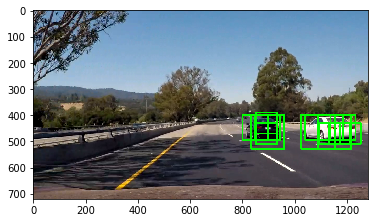

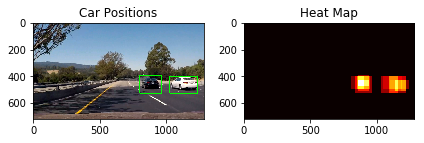








 59%|█████▉    | 23/39 [00:16<00:18,  1.17s/it]

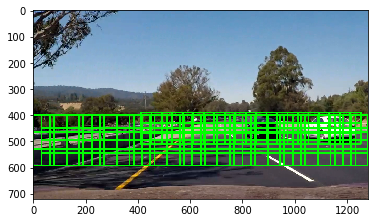

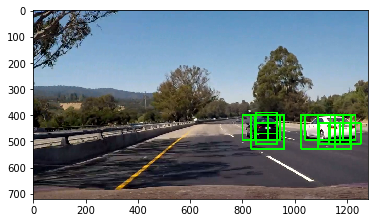

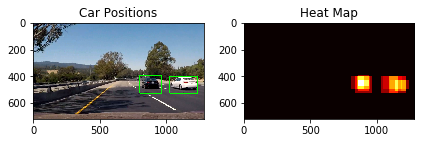








 62%|██████▏   | 24/39 [00:17<00:17,  1.19s/it]

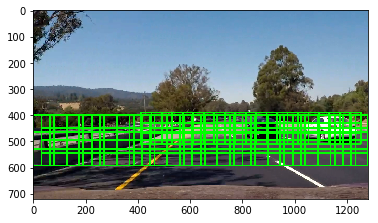

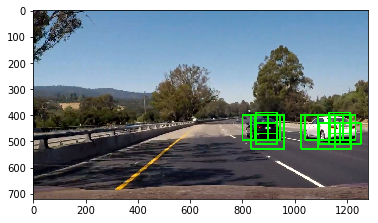

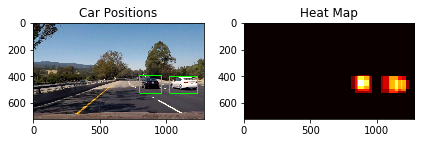








 64%|██████▍   | 25/39 [00:18<00:16,  1.21s/it]

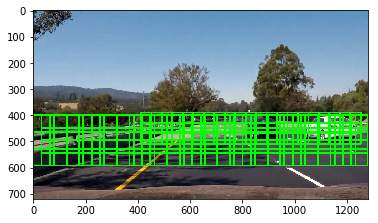

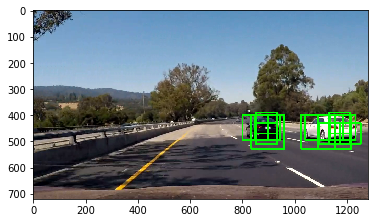

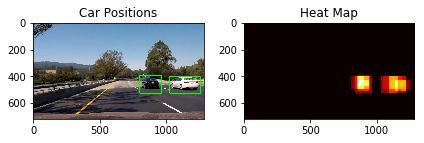








 67%|██████▋   | 26/39 [00:19<00:15,  1.19s/it]

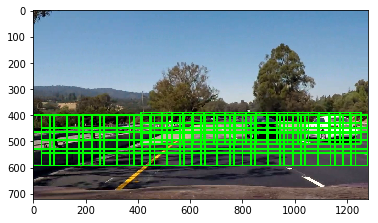

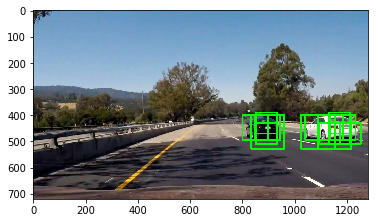

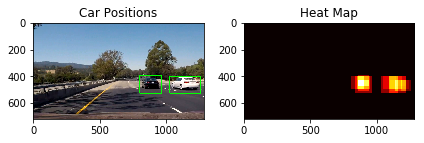








 69%|██████▉   | 27/39 [00:21<00:14,  1.20s/it]

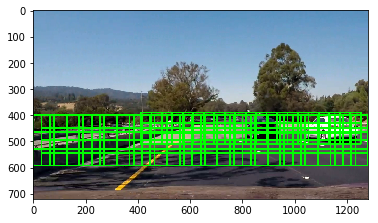

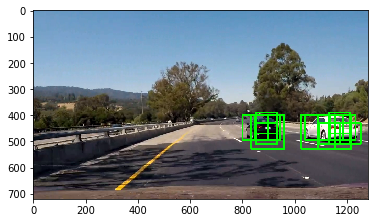

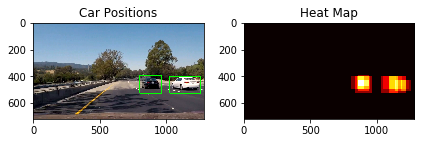








 72%|███████▏  | 28/39 [00:22<00:13,  1.24s/it]

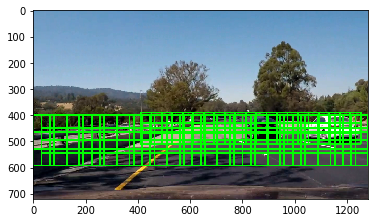

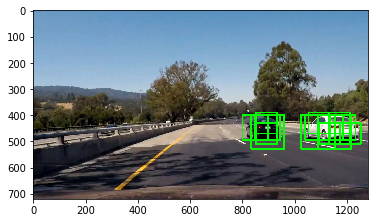

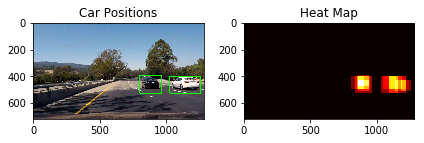








 74%|███████▍  | 29/39 [00:23<00:12,  1.25s/it]

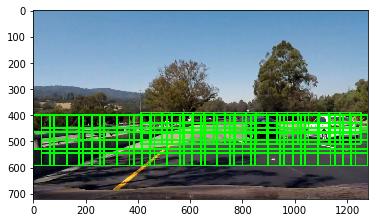

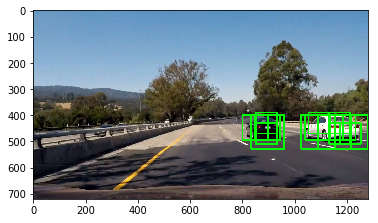

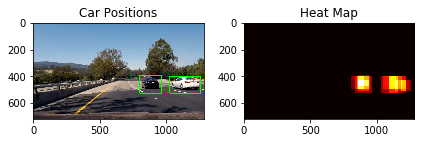








 77%|███████▋  | 30/39 [00:24<00:11,  1.24s/it]

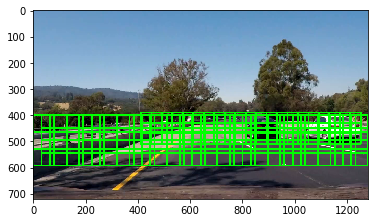

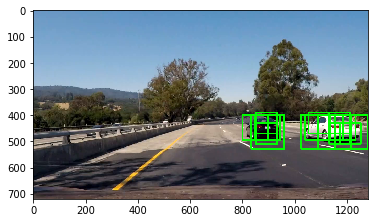

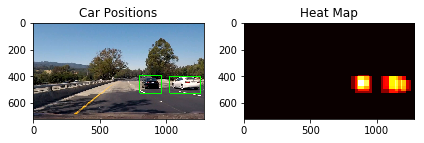








 79%|███████▉  | 31/39 [00:26<00:09,  1.23s/it]

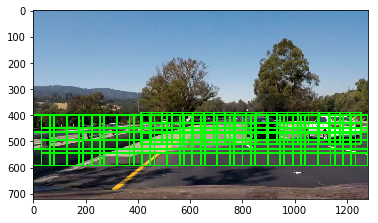

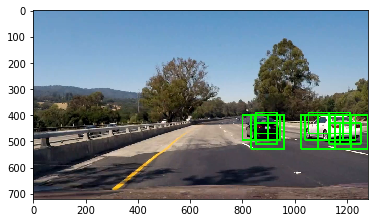

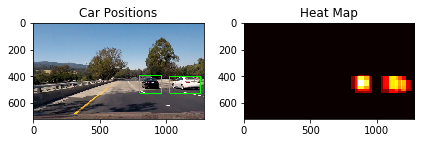








 82%|████████▏ | 32/39 [00:27<00:08,  1.21s/it]

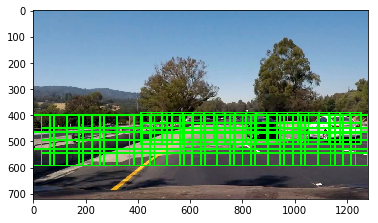

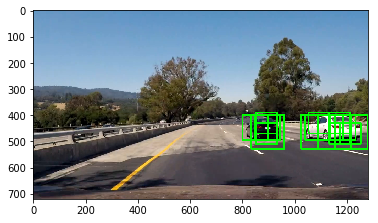

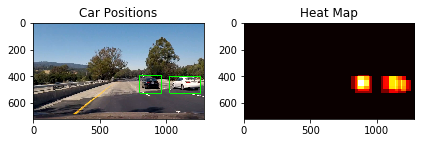








 85%|████████▍ | 33/39 [00:28<00:07,  1.19s/it]

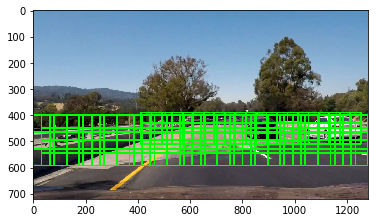

KeyboardInterrupt: 

In [116]:
# Create the video with bounding boxes
# drawn on top of the original video frames.
find_cars_in_video(
    input_video_path='test_video.mp4', 
    pipeline=pipeline, 
    output_video_path='tracking.mp4'
)

In [45]:
plt.show()